# RL coursework, part I (20 pts total)
---

**SN:** 15066212

---

**Due date:** *29th March, 2022, - EC apply*

---

Standard UCL policy (including grade deductions) automatically applies for any late submissions.

## How to submit

When you have completed the exercises and everything has finished running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as **`<studentnumber>_RL_part1.ipynb`** before the deadline above, where `<studentnumber>` is your student number.

**Context**

In this assignment, we will take a first look at learning decisions from data.  For this, we will use the multi-armed bandit framework.

**Background reading**

* Sutton and Barto (2018), Chapters 1 to 6
* Lecture slides

**Overview of this assignment**

A) You will use Python to implement several bandit algorithms.

B) You will then run these algorithms on a multi-armed Bernoulli bandit problem, and answer question about their empirical performance.

C) You will then be asked to reason about the behaviour of different algorithms

## Setup

Run each of the cells below, until you reach the next section **Basic Agents**. You do not have to read or understand the code in the **Setup** section.  After running the cells, feel free to fold away the **Setup** section.

In [3]:
# Import Useful Libraries

import collections
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import random

np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-notebook')

In [4]:
class BernoulliBandit(object):
  """A stationary multi-armed Bernoulli bandit."""

  def __init__(self, success_probabilities, success_reward=1., fail_reward=0.):
    """Constructor of a stationary Bernoulli bandit.

    Args:
      success_probabilities: A list or numpy array containing the probabilities,
          for each of the arms, of providing a success reward.
      success_reward: The reward on success (default: 1.)
      fail_reward: The reward on failure (default: 0.)
    """
    self._probs = success_probabilities
    self._number_of_arms = len(self._probs)
    self._s = success_reward
    self._f = fail_reward

    ps = np.array(success_probabilities)
    self._values = ps * success_reward + (1 - ps) * fail_reward

  def step(self, action):
    """The step function.

    Args:
      action: An integer or np.int32 that specifies which arm to pull.

    Returns:
      A reward sampled according to the success probability of the selected arm.

    Raises:
      ValueError: when the provided action is out of bounds.
    """
    if action < 0 or action >= self._number_of_arms:
      raise ValueError('Action {} is out of bounds for a '
                       '{}-armed bandit'.format(action, self._number_of_arms))

    success = bool(np.random.random() < self._probs[action])
    reward = success * self._s + (not success) * self._f
    return reward

  def regret(self, action):
    """Computes the regret for the given action."""
    return self._values.max() - self._values[action]

  def optimal_value(self):
    """Computes the regret for the given action."""
    return self._values.max()


In [5]:
class NonStationaryBandit(object):
  """A non-stationary multi-armed Bernoulli bandit."""

  def __init__(self, success_probabilities,
               success_reward=1., fail_reward=0., change_point=800,
               change_is_good=True):
    """Constructor of a non-stationary Bernoulli bandit.

    Args:
      success_probabilities: A list or numpy array containing the probabilities,
          for each of the arms, of providing a success reward.
      success_reward: The reward on success (default: 1.)
      fail_reward: The reward on failure (default: 0.)
      change_point: The number of steps before the rewards change.
      change_is_good: Whether the rewards go up (if True), or flip (if False).
    """
    self._probs = success_probabilities
    self._number_of_arms = len(self._probs)
    self._s = success_reward
    self._f = fail_reward
    self._change_point = change_point
    self._change_is_good = change_is_good
    self._number_of_steps_so_far = 0

    ps = np.array(success_probabilities)
    self._values = ps * success_reward + (1 - ps) * fail_reward

  def step(self, action):
    """The step function.

    Args:
      action: An integer or np.int32 that specifies which arm to pull.

    Returns:
      A reward sampled according to the success probability of the selected arm.

    Raises:
      ValueError: when the provided action is out of bounds.
    """
    if action < 0 or action >= self._number_of_arms:
      raise ValueError('Action {} is out of bounds for a '
                       '{}-armed bandit'.format(action, self._number_of_arms))

    self._number_of_steps_so_far += 1
    success = bool(np.random.random() < self._probs[action])
    reward = success * self._s + (not success) * self._f
    
    if self._number_of_steps_so_far == self._change_point:
      # After some number of steps, the rewards are inverted
      #
      #  ``The past was alterable. The past never had been altered. Oceania was
      #    at war with Eastasia. Oceania had always been at war with Eastasia.``
      #            - 1984, Orwell (1949).
      reward_dif = (self._s - self._f)
      if self._change_is_good:
        self._f = self._s + reward_dif
      else:
        self._s -= reward_dif
        self._f += reward_dif
      
      # Recompute expected values when the rewards change
      ps = np.array(self._probs)
      self._values = ps * self._s + (1 - ps) * self._f

    return reward
  
  def regret(self, action):
    """Computes the regret for the given action."""
    return self._values.max() - self._values[action]
  
  def optimal_value(self):
    """Computes the regret for the given action."""
    return self._values.max()

In [6]:
# Helper functions

def smooth(array, smoothing_horizon=100., initial_value=0.):
  """Smoothing function for plotting."""
  smoothed_array = []
  value = initial_value
  b = 1./smoothing_horizon
  m = 1.
  for x in array:
    m *= 1. - b
    lr = b/(1 - m)
    value += lr*(x - value)
    smoothed_array.append(value)
  return np.array(smoothed_array)

def plot(algs, plot_data, repetitions=30):
  """Plot results of a bandit experiment."""
  algs_per_row = 4
  n_algs = len(algs)
  n_rows = (n_algs - 2)//algs_per_row + 1
  fig = plt.figure(figsize=(10, 4*n_rows))
  fig.subplots_adjust(wspace=0.3, hspace=0.35)
  clrs = ['#000000', '#00bb88', '#0033ff', '#aa3399', '#ff6600']
  lss = ['--', '-', '-', '-', '-']
  for i, p in enumerate(plot_data):
    for c in range(n_rows):
      ax = fig.add_subplot(n_rows, len(plot_data), i + 1 + c*len(plot_data))
      ax.grid(0)

      current_algs = [algs[0]] + algs[c*algs_per_row + 1:(c + 1)*algs_per_row + 1]
      for alg, clr, ls in zip(current_algs, clrs, lss):
        data = p.data[alg.name]
        m = smooth(np.mean(data, axis=0))
        s = np.std(smooth(data.T).T, axis=0)/np.sqrt(repetitions)
        if p.log_plot:
          line = plt.semilogy(m, alpha=0.7, label=alg.name,
                              color=clr, ls=ls, lw=3)[0]
        else:
          line = plt.plot(m, alpha=0.7, label=alg.name,
                          color=clr, ls=ls, lw=3)[0]
          plt.fill_between(range(len(m)), m + s, m - s,
                           color=line.get_color(), alpha=0.2)
      if p.opt_values is not None:
        plt.plot(p.opt_values[current_algs[0].name][0], ':', alpha=0.5,
                 label='optimal')

      ax.set_facecolor('white')
      ax.tick_params(axis="both", which="both", bottom="off", top="off",
                     labelbottom="on", left="off", right="off", labelleft="on")
      ax.spines["top"].set_visible(False)
      ax.spines["bottom"].set(visible=True, color='black', lw=1)
      ax.spines["right"].set_visible(False)
      ax.spines["left"].set(visible=True, color='black', lw=1)
      ax.get_xaxis().tick_bottom()
      ax.get_yaxis().tick_left()

      data = np.array([smooth(np.mean(d, axis=0)) for d in p.data.values()])
      
      if p.log_plot:
        start, end = calculate_lims(data, p.log_plot)
        start = np.floor(np.log10(start))
        end = np.ceil(np.log10(end))
        ticks = [_*10**__
                 for _ in [1., 2., 3., 5.]
                 for __ in [-2., -1., 0.]]
        labels = [r'${:1.2f}$'.format(_*10** __)
                  for _ in [1, 2, 3, 5]
                  for __ in [-2, -1, 0]]
        plt.yticks(ticks, labels)
      plt.ylim(calculate_lims(data, p.log_plot))
      plt.locator_params(axis='x', nbins=4)
      
      plt.title(p.title)
      if i == len(plot_data) - 1:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

def run_experiment(bandit_constructor, algs, repetitions, number_of_steps):
  """Run multiple repetitions of a bandit experiment."""
  reward_dict = {}
  regret_dict = {}
  optimal_value_dict = {}

  for alg in algs:
    reward_dict[alg.name] = np.zeros((repetitions, number_of_steps))
    regret_dict[alg.name] = np.zeros((repetitions, number_of_steps))
    optimal_value_dict[alg.name] = np.zeros((repetitions, number_of_steps))

    for _rep in range(repetitions):
      bandit = bandit_constructor()
      alg.reset()

      action = None
      reward = None
      for _step in range(number_of_steps):
        action = alg.step(action, reward)
        reward = bandit.step(action)
        regret = bandit.regret(action)
        optimal_value = bandit.optimal_value()

        reward_dict[alg.name][_rep, _step] = reward
        regret_dict[alg.name][_rep, _step] = regret
        optimal_value_dict[alg.name][_rep, _step] = optimal_value

  return reward_dict, regret_dict, optimal_value_dict


def train_agents(agents, number_of_arms, number_of_steps, repetitions=100,
                 success_reward=1., fail_reward=0.,
                 bandit_class=BernoulliBandit):

  success_probabilities = np.arange(0.3, 0.7 + 1e-6, 0.4/(number_of_arms - 1))

  bandit_constructor = partial(bandit_class,
                               success_probabilities=success_probabilities,
                               success_reward=success_reward,
                               fail_reward=fail_reward)
  rewards, regrets, opt_values = run_experiment(
      bandit_constructor, agents, repetitions, number_of_steps)

  smoothed_rewards = {}
  for agent, rs in rewards.items():
    smoothed_rewards[agent] = np.array(rs)

  PlotData = collections.namedtuple('PlotData',
                                    ['title', 'data', 'opt_values', 'log_plot'])
  total_regrets = dict([(k, np.cumsum(v, axis=1)) for k, v in regrets.items()])
  plot_data = [
      PlotData(title='Smoothed rewards', data=smoothed_rewards,
               opt_values=opt_values, log_plot=False),
      PlotData(title='Current Regret', data=regrets, opt_values=None,
               log_plot=True),
      PlotData(title='Total Regret', data=total_regrets, opt_values=None,
               log_plot=False),
  ]

  plot(agents, plot_data, repetitions)

def calculate_lims(data, log_plot=False):
  y_min = np.min(data)
  y_max = np.max(data)
  diff = y_max - y_min
  if log_plot:
    y_min = 0.9*y_min
    y_max = 1.1*y_max
  else:
    y_min = y_min - 0.05*diff
    y_max = y_max + 0.05*diff
  return y_min, y_max

def argmax(array):
  """Returns the maximal element, breaking ties randomly."""
  return np.random.choice(np.flatnonzero(array == array.max()))

# A) Agent implementations


All agents should be in pure Python/NumPy.

You cannot use any AutoDiff packages (Jax, TF, PyTorch, etc.)

Each agent, should implement the following methods:

**`step(self, previous_action, reward)`:**

Should update the statistics by updating the value for the previous_action towards the observed reward.

(Note: make sure this can handle the case that previous_action=None, in which case no statistics should be updated.)

(Hint: you can split this into two steps: 1. update values, 2. get new action.  Make sure you update the values before selecting a new action.)

**`reset(self)`:**

Resets statistics (should be equivalent to constructing a new agent from scratch).

Make sure that the initial values (after a reset) are all zero.

**`__init__(self, name, number_of_arms, *args)`:**

The `__init__` should take at least an argument `number_of_arms`, and (potentially) agent specific args.

## Example agent

The following code block contains an example random agent.

In [7]:
class Random(object):
  """A random agent.

  This agent returns an action between 0 and 'number_of_arms', uniformly at
  random. The 'previous_action' argument of 'step' is ignored.
  """

  def __init__(self, name, number_of_arms):
    """Initialise the agent.
    
    Sets the name to `random`, and stores the number of arms. (In multi-armed
    bandits `arm` is just another word for `action`.)
    """
    self._number_of_arms = number_of_arms
    self.name = name

  def step(self, unused_previous_action, unused_reward):
    """Returns a random action.
    
    The inputs are ignored, but this function still requires an action and a
    reward, to have the same interface as other agents who may use these inputs
    to learn.
    """
    return np.random.randint(self._number_of_arms)

  def reset(self):
    pass


## Q1 [2 pts]
Implement a UCB agent.

The `bonus_multiplier` is the parameter $c$ from the slides.

In [8]:
class UCB(object):
  def __init__(self, name, number_of_arms, bonus_multiplier):
    self._number_of_arms = number_of_arms
    self._bonus_multiplier = bonus_multiplier
    self.name = name # In this case it would set the name to UCB, to keep track of what sort of agent we are using.
    self.Qs = np.zeros(self._number_of_arms)
    self.Ns = np.zeros(self._number_of_arms)
    self.t = 0
    self.reset()

  def step(self, previous_action, reward):
    eps = 1e-6
    self.t += 1
    if previous_action is not None:
      self.Ns[previous_action] += 1
      self.Qs[previous_action] = self.Qs[previous_action] + 1/self.Ns[previous_action] * (reward - self.Qs[previous_action])
    ucb_func = self.Qs + self._bonus_multiplier * np.sqrt(np.log(self.t)/(self.Ns+eps))
    action = random.choice(np.argwhere(ucb_func == np.max(ucb_func)).flatten()) # choose action with highest value with random tie-breaker
    return action

  def reset(self):
    self.Qs = np.zeros(self._number_of_arms)
    self.Ns = np.zeros(self._number_of_arms)
    self.t = 0

## Q2 [1 pt]
Implement an $\epsilon$-greedy agent.

This agent should be able to support time-changing $\epsilon$ schedules.

Thus, your agent should accept both constants and callables as constructor argument `epsilon`; callables are used to decay the $\epsilon$ parameter over time, for instance according to a polynomial schedule: $\epsilon_t = t^{-\eta}$ with $\eta \in [0, 1]$).


If multiple actions have the same value, ties should be broken randomly.

In [9]:
class EpsilonGreedy(object):
  """An epsilon-greedy agent.

  This agent returns an action between 0 and 'number_of_arms'; with probability
  `(1-epsilon)` it chooses the action with the highest estimated value, while
  with probability `epsilon` it samples an action uniformly at random.
  """

  def __init__(self, name, number_of_arms, epsilon=0.1):
    self.name = name
    self._number_of_arms = number_of_arms
    self._epsilon = epsilon
    self.Qs = np.zeros(self._number_of_arms)
    self.Ns = np.zeros(self._number_of_arms)
    self.t = 0
    self.reset()

  def step(self, previous_action, reward):
    """Update the learnt statistics and return an action.

    A single call to step uses the provided reward to update the value of the
    taken action (which is also provided as an input), and returns an action.
    The action is either uniformly random (with probability epsilon), or greedy
    (with probability 1 - epsilon).

    If the input action is None (typically on the first call to step), then no
    statistics are updated, but an action is still returned.
    """
    self.t += 1

    try:
      e = self._epsilon(self.t) # epsilon is a function of t
    except:
      e = self._epsilon # epsilon is a constant value

    if previous_action is not None:
      self.Ns[previous_action] += 1
      self.Qs[previous_action] = self.Qs[previous_action] + 1/self.Ns[previous_action] * (reward - self.Qs[previous_action])
    
    if np.random.uniform() <= e: # random action
      action = random.randint(0,self._number_of_arms-1)
    else:
      action = random.choice(np.argwhere(self.Qs == np.max(self.Qs)).flatten()) # choose action with highest value with random tie-breaker
    
    return action

  def reset(self):
    self.Qs = np.zeros(self._number_of_arms)
    self.Ns = np.zeros(self._number_of_arms)
    self.t = 0

## Q3 [2 pts]
Implement a REINFORCE agent.

While `softmax` distributions are a common parametrization for policies over discrete action-spaces, they are not the only choice. In this exercise we ask you to implement REINFORCE with the `square-max` policy parameterization. With this parametrisation the probabilities depend on the action preferences $p(\cdot)$ according to the expression:

$$\pi(a) = \frac{p(a)^2}{\sum_b p(b)^2}\,.$$

Implement a REINFORCE policy-gradient method for updating the preferences under this policy distribution. The action preferences are stored separately, so that for each action $a$ the preference $p(a)$ is a single value that you directly update.

The agent should be able to use a baseline or not (as defined in the constructor). The `step_size` parameter $\alpha$ used to update the policy must also be configurable in the constructor.

The baseline should track the average reward so far, using the same `step_size` used to update the policy.

The `step_size` and whether or not a baseline is used are defined in the constructor by feeding additional arguments in place of `...` below.


In [25]:
class REINFORCE(object):
  def __init__(self, name, number_of_arms, step_size=0.1, baseline=False):
    self.name = name
    self._number_of_arms = number_of_arms
    self._step_size = step_size
    self._baseline = baseline
    self.ps = np.ones(self._number_of_arms)
    self.pis = self.ps**2 / np.sum(self.ps**2)
    self.b = 0
    # self.t = 0 # No need to track time steps with policy gradients
    self.reset()

  def step(self, previous_action, reward):
    # self.t += 1

    if previous_action is not None:
      if self._baseline == False:
        self.ps[previous_action] = self.ps[previous_action] + self._step_size * reward * 2 * (1/self.ps[previous_action] - self.ps[previous_action]/np.sum(self.ps**2))
        self.ps[:previous_action] = self.ps[:previous_action] - self._step_size * reward * 2 * self.ps[:previous_action]/np.sum(self.ps**2)
        self.ps[previous_action+1:] = self.ps[previous_action+1:] - self._step_size * reward * 2 * self.ps[previous_action+1:]/np.sum(self.ps**2)
      else:
        self.b += self._step_size * (reward - self.b)
        self.ps[previous_action] = self.ps[previous_action] + self._step_size * (reward-self.b) * 2 * (1/self.ps[previous_action] - self.ps[previous_action]/np.sum(self.ps**2))
        self.ps[:previous_action] = self.ps[:previous_action] - self._step_size * (reward-self.b) * 2 * self.ps[:previous_action]/np.sum(self.ps**2)
        self.ps[previous_action+1:] = self.ps[previous_action+1:] - self._step_size * (reward-self.b) * 2 * self.ps[previous_action+1:]/np.sum(self.ps**2)

    self.pis = self.ps**2 / np.sum(self.ps**2)

    action = np.random.choice(a=np.array(list(range(self._number_of_arms))), p=self.pis) # choose action according to policy probabilities

    return action

  def reset(self):
    self.ps = np.ones(self._number_of_arms)
    self.pis = self.ps**2 / np.sum(self.ps**2)
    self.b = 0
    # self.t = 0

# B) Experiments

**Run the cell below to train the agents and generate the plots for the first experiment.**

Trains the agents on a Bernoulli bandit problem with 5 arms,
with a reward on success of 1, and a reward on failure of 0.

## Experiment 1: Bernoulli bandit

In [26]:
%%capture experiment1

number_of_arms = 5
number_of_steps = 1000

agents = [
    Random(
        "random",
        number_of_arms),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon=0$",
        number_of_arms,
        epsilon=0.),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon=0.1$",
        number_of_arms,
        epsilon=0.1),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon_t=1/t$",
        number_of_arms,
        epsilon=lambda t: 1./t),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon_t=1/\sqrt{t}$",
        number_of_arms,
        epsilon=lambda t: 1./t**0.5),
    UCB("UCB",
        number_of_arms,
        bonus_multiplier=1/np.sqrt(2)),
    REINFORCE(
        r"REINFORCE, $\alpha=0.1$",
        number_of_arms,
        step_size=0.1,
        baseline=False),
    REINFORCE(
        r"REINFORCE with baseline, $\alpha=0.1$",
        number_of_arms,
        step_size=0.1,
        baseline=True),
]

train_agents(agents, number_of_arms, number_of_steps)

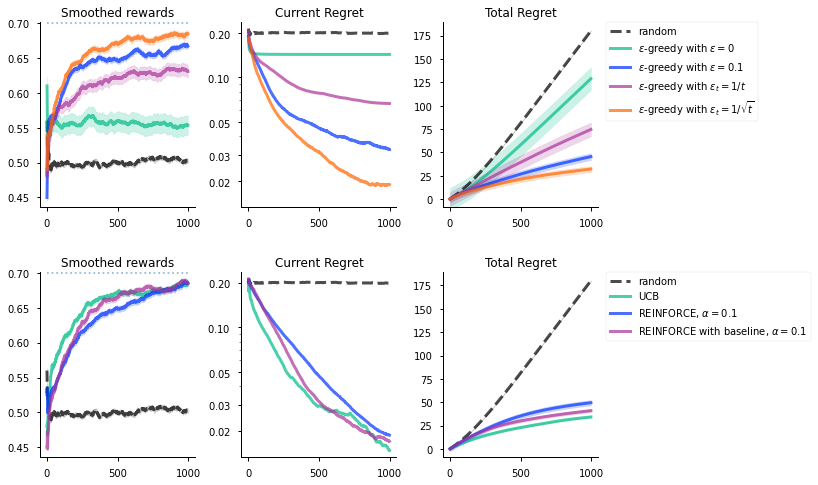

In [27]:
experiment1.show()

## Q4 [4 pts total]
(Answer inline in the markdown below each question, **within this text cell**.)

**[2 pts]**
For each algorithm in the plots above, explain whether or not we should be expected it to be good in general, in terms of total regret.

- The random algorithm is not expected to be good, since it does not follow any criteria for minimising the total regret. It just chooses actions randomly at every step without really learning anything, so total regret will always keep increasing.

- The greedy algorithm ($\epsilon$ = 0) is not expected to be good since it always exploits current knowledge to maximise immediate reward and it does not explore at all actions that seem less optimal at the time but could eventually end up being better than the current best action, and result in higher expected reward (or smaller total regret). This could be improved by forcing some exploration in the early steps, setting optimistic initial values for approximated action values, but this is not the case in our code.

- The $\epsilon$-greedy algorithms where $\epsilon$ ≠ 0, are expected to work better than the purely greedy algorithm, since they allow for more exploration However, total regret is still expected to increase linearly forever, since we will still keep choosing sub-optimal actions with some probability once we have found the optimal action. More about this in the next part of the question.

- The UCB algorithm is expected to have small total regret, since it combines exploration and exploitation by prioritising uncertainty. Therefore, it will explore actions which we do not have much information about and have a broad confidence interval with higher upper bound than any other action. As the uncertain actions are selected, the more we know about them and the smaller their confidence interval becomes, which simply leads the algorithm to exploit the actions with highest expected value. This algorithm has logarithmic total regret, so the regret will always increase, but at a slowing rate as number of steps increases and the agent learns.

- REINFORCE is also expected to be good. This algorithm learns directly the action policy (i.e. the probabilities with which to choose each action), though action preferences, without having to calcukate the expected action values. The total regret increases linarly but at a very slow rate. The REINFORCE algorithm with baseline performs even better by converging to the true policy faster by reducing the variance of the update in the optimisation.

**[2 pts]** Explain the relative ranking of the $\epsilon$-greedy algorithms in this experiment.

- As explained above, the purely greedy algorithm with $\epsilon$ = 0 is the worst performing one, since when an action gets an expected reward higher than zero, the agent will pick that one action forever, without exploring any of the other actions and whether they would end up being better in the long run.

- $\epsilon$-greedy algorithm with constant $\epsilon$ performs better than the purely greedy, since it enforces exploration with probability $\epsilon$, which will help find the optimal action (with infinite time steps, all the actions will have been chosen enough times such that the approximate action values will be close to their ture values). However, once the optimal value is found, we'll keep picking suboptimal with probability ($\epsilon$ - $\epsilon$/num. actions), and therefore, the total regret will keep increasing forever.

- $\epsilon$-greedy algorithm with decreasing $\epsilon$ with time steps work better or worse depeding on the rate at which $\epsilon$ is decreasing. In the case where $\epsilon$ = 1/t, $\epsilon$ becomes too samll too fast and so the algorithm basically stops exploring before it has had time to find the optimal action, and therefore, it then exploits a suboptimal action, resulting in a forever increasing total regret at a much higher rate than the $\epsilon$-greedy with fixec $\epsilon$ = 0.1. On the other hand, when $\epsilon$ = 1/$\sqrt{t}$, $\epsilon$ decreases at a slower rate giving the agent enough time to find the optimal action when exploring, and then explot that action with decreasing exploration on sub-obtimal actions, resulting in the lowest total regret among the $\epsilon$-greedy algorithms. 
Note: it is curious to see that the algorithm with constant $\epsilon$ = 0.1 performs almost as good as the algorithm with decreasing $\epsilon$ = 1/$\sqrt{t}$. This might be because 0.1 is a good choice for $\epsilon$ in this case, and also, when exploring with probability $\epsilon$, we might still choose the optimal action.

## Experiment 2: reward = 0 on success, reward = -1 on failure.

**Run the cell below to train the agents and generate the plots for the second experiment.**
Reruns experiment 1 but on a different bernoulli bandit problem with 5 arms,
with a reward on success of 0, and a reward on failure of -1.

---



In [28]:
%%capture experiment2
number_of_arms = 5
number_of_steps = 1000

train_agents(agents, number_of_arms, number_of_steps,
             success_reward=0., fail_reward=-1.)

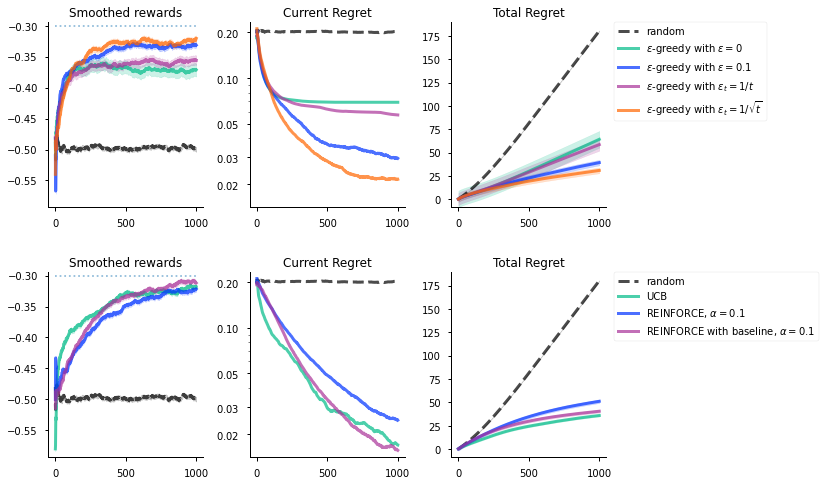

In [29]:
experiment2.show()

## Q5 [2 pts]
For each algorithm, note whether the performance changed significantly compared to the **experiment 1**, and explain why it did or did not.

(Use at most two sentences per algorithm).

On an overall note, the relative ranking of the $\epsilon$-greedy algorithms has stayed the same, but the performance of the non-exploratory ones has improved drastically.

- $\epsilon$-greedy ($\epsilon$ = 0): the performance has significantly improved because now the expected reward never increases, it either decreases for non-optimal actions, or stays the same for optimal actions. Therefore, the greedy algorithm will not get stuck in the early stages in an action that gives some success, but will explore all the actions (because even if we have a success, the expected action value will stay 0, so we will be forced to try other actions due to the random tie-breaking policy) and eventually stay on the action that has the least amount of failures (i.e. the optimal action).
- $\epsilon$-greedy ($\epsilon$ = 0.1): it has not changed much, since we still have both exploration and exploitation. But in this case, when we exploit in early time steps, we actually explore due to the new reward system.
- $\epsilon$-greedy ($\epsilon$ = 1/t): it improves significantly, for similar reasons to $\epsilon$-greedy ($\epsilon$ = 0), since $\epsilon$ = 1/t reduces $\epsilon$ to zero very quickly resulting in the purely greedy case.
- $\epsilon$-greedy ($\epsilon$ = 1/$\sqrt{t}$): there is no significant improvement, since in the previous experiment the algorithm was already able to identify the optimal action by exploring in the early stages, and then exploiting that action in later time steps without any further exploration on non-optimal actions (because $\epsilon$ converges to zero). In this new experiemnt, we have the same case, but in the earlier stages we have even more exploration, since when we "exploit", we are effectively exploring due to the new rewards system.
- UCB: very similar results to experiment 1, since the algorithm itself already prioritised unseen actions (which is what this new reward system enforces at the beginning).
- REINFORCE with and without baseline: very similar results to experiment 1. The new reward system makes the action preferences to stay the same for optimal actions, or decrease for sub-optimal actions, which makes the algorithm explore more at early time steps, but the overall mechanics is the same as before: in experiment 1, the preferences were updated on successes (optimal actions preferences go up, and the rest go down), whereas in this experiment we update the preferences on failures (optimal action preferences go down, and the rest go up).

## Run the following cells

## Experiment 3: Non-stationary bandit
 * Reward on `failure` changes from 0 to +2.
 * Reward on `success` remains at +1.


In [30]:
%%capture experiment3

number_of_arms = 3
number_of_steps = 1984
agents = [
    Random(
        "random",
        number_of_arms),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon=0.1$",
        number_of_arms,
        epsilon=0.1),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon_t=1/\sqrt{t}$",
        number_of_arms,
        epsilon=lambda t: 1./t**0.5),
    UCB("UCB",
        number_of_arms,
        bonus_multiplier=1/np.sqrt(2)),
    REINFORCE(
        r"REINFORCE with baseline, $\alpha=0.1$",
        number_of_arms,
        step_size=0.1,
        baseline=True),

]

roving_bandit_class = partial(NonStationaryBandit, change_is_good=True)
train_agents(agents, number_of_arms, number_of_steps,
             bandit_class=roving_bandit_class)

## Experiment 4: Non-stationary bandit
 * Reward on `failure` changes from 0 to +1.
 * Reward on `success` changes from +1 to 0.


In [31]:
%%capture experiment4

number_of_arms = 3
number_of_steps = 1984


roving_bandit_class = partial(NonStationaryBandit, change_is_good=False)
train_agents(agents, number_of_arms, number_of_steps,
             bandit_class=roving_bandit_class)

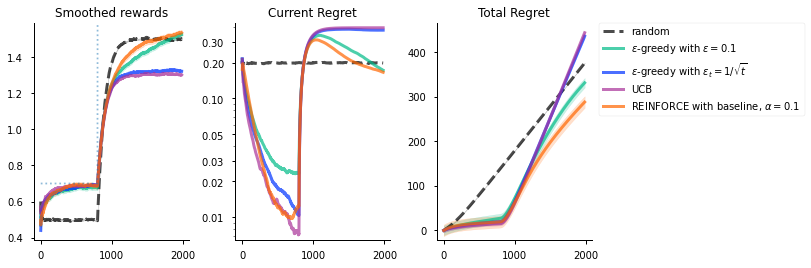

In [32]:
experiment3.show()

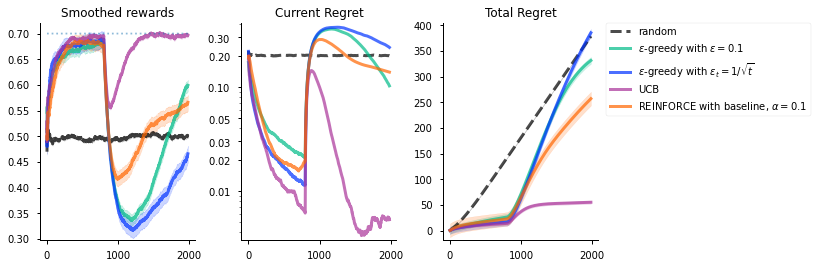

In [33]:
experiment4.show()

## Q6 [9 pts total]

Observe the reward and regret curves above.  After 800 steps, the rewards change. In **experiment 3** `success` continues to yield a reward of +1, but `failure` changes from a reward of 0 to a reward of +2.  In **experiment 4**, `success` is now worth 0 and `failure` is worth +1.

Below, we ask for explanations.  Answer each question briefly, using at most three sentences per question.

**[2 pts]** In **experiment 3** explain the ranking in current regret after the change in rewards for all algorithms.

After we change the reward for failures from 0 to +2, the current regret for all algorithms increases drastrically, surpassing the random agent, since our agents have been trained to choose optimal actions, and hence they have to re-learn to now choose the previously sub-obtimal actions (that fail more often) that now have higher rewards. For the $\epsilon$-greedy algorithms, the value of $\epsilon$ defines the grade of exploration. Hence, $\epsilon$ = 0.1 explores relatively often and so the action values can be readjusted fairly quickly according to the new rewards. For $\epsilon$-greedy = 1/$\sqrt{t}$, after 800 iterations, $\epsilon$ is already very small, allowing for very little exploration, so it will take longer for the action values to re-adjust (and exploit the right actions), and for the regret to decrease. In a smiliar way, the UCB algorithm barely explores at this point, since the greedy action still yields a reward of +1, so its current regret decreases very slowly. In REINFORCE, we are not picking the greedy action, but instead sampling the action from a distribution that favoured the optimal action, but with the new rewards, whenever a sub-optimal action is chosen, the new reward of +2 will make the distribution to be updated and give more preferences to the other actions, which is why the algorithm adapts quickly.

**[2 pts]** In **experiment 4** explain the ranking in current regret after the change in rewards for all algorithms.

$\epsilon$-greedy adapt faster or slower depending on the grade of exploration specified by $\epsilon$ (as explained in Experiment 3), but they seem to adapt faster than in Experiment 3 because the optimal action now has zero reward, so its action value decreases, whilst the value of sub-optimal actions increases when they fail, and therefore they become greedy actions quicker. REINFORCE performs in a similar manner as explained in Experiment 3. UCB now performes way better than in Experiemnt 3, it is the algorithm that adapts the fastest, because as the action value of the greedy action reduces, its upper bound value also reduces quickly as the action has very low uncertainty at large time steps, and therefore, more uncertain non-greedy actions are preferred and explored, resulting in faster adaptation and better performance.

**[2 pts]** Explain how and why the current-regret curve for UCB in **experiment 3** differs from the curve in **experiment 4**.

As explained in the questions above, the key lies in the fact that in Experiment 3, the reward for success is still +1 after the 800th time step, whereas in Experiment 4, the reward for success changes to 0. In Experiment 3, the action value of the greedy action keeps increasing (even though slower than in the non-greedy actions), and so it takes the upper bound value of the non-greedy actions a long time to surpass the greedy action: you have to wait for many time steps to pass until the uncertainty of the non-greedy actions is large enough. In Experiment 4, the action value of the greedy action decreases whereas the one of the non-greedy action increases, so the upper bound value catches up with the greedy action much faster, which results in much better performance.

**[3 pts]** In general, if rewards can be non-stationary, and we don't know the exact nature of the non-stationarity, how could we modify UCB to perform better?   Be specific and concise.

The main idea here is that we want to prioritise exploration whenever the rewards change, so that the upper bound value can quickly identify the actions that yield higher reward and exploit them. This problem could be solved by giving more weight to recent rewards, and therefore, when rewards change, the new rewards will have a higher effect on the action values and consequently on the upper bound value, where the uncertainty term will have more weight, and give preference to other actions (exploration) that might have higher updated rewards, and consequently become the new greedy actions. There is one existing algorithm that operates like this, called "discounted Upper Confidence Bound".
